In [6]:
import glob
import os
import pandas as pd
import argparse
import subprocess
import re
from IPython.core import display as ICD
from os import listdir
from multiprocessing import cpu_count
from multiprocessing import Pool
from shutil import rmtree
from subprocess import check_output

# Timeseries Pull & Averaging

## Table of Conents:

* [Get Input Data](#input)
* [Transform functionals with flirt and fslmath](#transform)
* [Pull individual ROI timeseries by subject](#pulltimeseries)


Steps:
1. Pull *uncorrected* timeseries from functionals  
2. Create functional connectivity matrices(FCMs) for each subject per run 
3. Average the FCMs across runs

In [29]:
# load and set variables
data_path='/projects/niblab/experiments/chocolate_milkshake/data'
beta_path='/projects/niblab/experiments/chocolate_milkshake/data/betaseries'
concat_path="/projects/niblab/experiments/chocolate_milkshake/data/betaseries/concat_niftis"
subject_folders=sorted(glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/preprocessed/sub-*'))

data_dict={}
bad_subs=[]


In [ ]:
subje

In [30]:
"""
# Helper Functions
#
"""

def chunks(l,n):
    return [l[i:i+n] for i in range(0, len(l), n)]


In [31]:
# get functionals 
functional_niis=glob.glob(os.path.join(data_path, "preprocessed/sub-*/ses-1/func/*brain.nii.gz"))
print("Functional nifti files found: {}".format(len(functional_niis)))



Functional nifti files found: 343


In [32]:
for func_file in functional_niis[:3]:
    #print(func_file.split("/")[-1])
    subj_id = func_file.split("/")[-1].split("_")[0]
    task_id = func_file.split("/")[-1].split("_")[2]
    print(subj_id, task_id)
    if 'imagine' in task_id:
        pass
    else:
        if subj_id not in data_dict:
            data_dict[subj_id]={}
        if task_id not in data_dict[subj_id]:
            data_dict[subj_id][task_id]={}




sub-001 task-milkshakeC
sub-001 task-milkshakeB
sub-001 task-imagine


In [26]:
def tranform_niftis(niftis):
    reference_nifti='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.nii.gz'
    reference_mat='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.mat'
    for nii in niftis:

        # setup and run flirt
        nii=nii.replace('.nii.gz', '')
        out=nii+'_3mm'
        flirt_cmd="flirt -in {} -ref {} -init {} -applyxfm -out {}".format(nii, reference_nifti, reference_mat, out)
        #print('[INFO] flirt command: \n{}'.format(flirt_cmd))
        os.system(flirt_cmd)

        fslmaths_cmd='fslmaths {} -thr 0.9 {}'.format(out,out)
        #print('[INFO] fslmaths command: \n{}'.format(fslmaths_cmd))
        os.system(fslmaths_cmd)

In [27]:

print('[INFO] transform functionals to match the mask.')
chunksize=10
funcs=functional_niis

# grab concatenated (fslmerge) data
#fslmerged_files[:4]
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(funcs, chunksize)
#print(len(chunk_list))
with Pool(12) as p:
    p.map(tranform_niftis, chunk_list)
print('[INFO] transformation process complete.')


[INFO] transform functionals to match the mask.
[INFO] chunksize: 10
[INFO] transformation process complete.


## Pull Timeseries <a class='anchor' id='pulltimeseries'></a>
  
  
**Pull individual ROI timeseries from the bigbrain300 atlas for each subject per condition**. 

Example command:  


    fslmeants -i ~/sub-001_punish.nii.gz -o ~/3_pull_timeseries/sub-001_punish_AI_35_23_-6_asymPREPspace.nii.gz.txt -m ~/AI_35_23_-6_asymPREPspace.nii.gz



In [31]:


def pull_timeseries(file_list, bb300_path='/projects/niblab/parcellations/bigbrain300',roi_df='/projects/niblab/parcellations/bigbrain300/renaming.csv'):

    
    bad_subs=[]
    #ICD.display(roi_df)

    # load asymmetrical nifti roi files
    asym_niftis=glob.glob("/projects/niblab/parcellations/bigbrain300/MNI152Asymmetrical_3mm/*.nii.gz")

    # load roi list
    out_dir = os.path.join(data_path, 'rois/bigbrain300/funcs_uc')
    #print('[INFO] output folder: \t%s \n'%out_dir)


    # loop through the roi file list
    #print(roi_list[:3])
    for nifti in sorted(file_list):

        subj_id = nifti.split("/")[-1].split("_")[0]
        task_id = nifti.split("/")[-1].split("_")[2]
        #print('[INFO] roi: %s %s \n%s'%(subj_id, task_id, nifti))

        # loop through roi reference list
        for ref_nifti in sorted(asym_niftis):
            #print('[INFO] reference roi: %s'%ref_nifti)
            roi = ref_nifti.split('/')[-1].split(".")[0]
            out_path = os.path.join(out_dir, "{}_{}_{}_{}.txt".format(subj_id, "ses-1", task_id, roi))
            #print(roi, out_path)
            cmd='fslmeants -i {} -o {} -m {}'.format(nifti, out_path, ref_nifti)
            try:
                #cmd='fslmeants -i {} -o {} -m {}'.format(nifti, out_path, ref_nifti)
                print("Running shell command: {}".format(cmd))
                #os.system(cmd)
                pass
            except:
                bad_subs.append((subj_id, task_id))
        
        #print('[INFO] finished processing for %s'%subj_id)
        

    return "%s"%bad_subs

   

In [37]:

# load roi
print("[INFO] loading roi and reference file....")

#subject_ids=[x.split("/")[-2] for x in glob.glob(os.path.join(data_path, 'preprocessed/sub-*/ses-1'))]
# get functionals 
funcs_3mm =glob.glob(os.path.join(data_path, "preprocessed/sub-*/ses-1/func/*milkshake*brain_3mm.nii.gz"))
print("Functional nifti files found: {}".format(len(funcs_3mm)))
chunksize=16
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(funcs_3mm, chunksize)
#roi_df['network']
# pull timeseries by rois --fslmeants command
#print(chunk_list)
def run_process(pool_size):
    print("[INFO] starting multiprocess...")
    with Pool(pool_size) as p:
        error_subjects=p.map(pull_timeseries, chunk_list)
    print("[INFO] process complete. \n[INFO] bad subjects: \t\t%s"%error_subjects)
    
pool_size=16
#run_process(pool_size)

[INFO] loading roi and reference file....
Functional nifti files found: 229
[INFO] chunksize: 16


In [39]:

!sbatch /projects/niblab/experiments/chocolate_milkshake/data/code/uc_ts_pull.job

Submitted batch job 3305433


In [6]:
!squeue -j 3305425
#!scancel 3305433 
#!squeue -u nbytes

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3305425     batch timeseri   nbytes  R   21:09:55      1 largemem-0-0


In [46]:
!ls /projects/niblab/experiments/chocolate_milkshake/data/error_files

timepull_beta_err_3185250.txt  timepull_out_3185250.txt
timepull_beta_err_3185251.txt  timepull_out_3185251.txt
timepull_beta_err_3185254.txt  timepull_out_3185254.txt
timepull_beta_err_3185256.txt  timepull_out_3185256.txt
timepull_beta_err_3185257.txt  timepull_out_3185257.txt
timepull_err_3305301.txt       timepull_out_3305301.txt


In [48]:
!cat /projects/niblab/experiments/chocolate_milkshake/data/error_files/timepull_err_3305301.txt

  File "/projects/niblab/experiments/chocolate_milkshake/data/code/uc_ts_pull.py", line 79
    """  
        ^
IndentationError: unindent does not match any outer indentation level


## Combine Timeseries<a class='anchor' id='combinetimeseries'></a>

**Combine individual rois for each subject and condition into a single matrix**

In [11]:
#!ls /projects/niblab/experiments/chocolate_milkshake/data/rois/bigbrain300/funcs_uc/sub-001*


# combining rois 
# sub-001_milkshakeC_
subj_rois=glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/rois/bigbrain300/funcs_uc/sub-001*milkshakeC*')
len(subj_rois)




300

In [33]:

# prep data dict


funcs=glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/preprocessed/sub-001/ses-1/func/sub-*brain.nii.gz')
data_dict

                

{'sub-001': {'task-milkshakeC': {}, 'task-milkshakeB': {}}}

In [45]:
error_subjects=[]
def timeseries_concat(subject_ids,verbose=True):
    
    for subject_id in subject_ids:
        
        tasks=list(data_dict[subject_id].keys())
        
        for task in tasks:
            

            #print(subject_id, task, stim)
            #print(os.path.join(beta_path, 'rois/big300/%s'%stim))
            # get roi texts for subject / condition
            roi_files = glob.glob(os.path.join(data_path, 'rois/bigbrain300/funcs_uc/%s*%s*.txt'%(subject_id,task)))

            df_lst=[]
            #print(roi_files)
            
            
            try:
                for txt in roi_files: 
                    #print(txt)
                    df_temp = pd.read_csv(txt, sep="\n", header=None)
                    #print(df_temp)
                    df_lst.append(df_temp)
                #print(subject_id, task, len(df_lst))

                df_concat= pd.concat(df_lst, axis=1, sort=False)
                #print(df_concat)

                # write output file 
                
                if not os.path.exists(os.path.join(data_path,'subject_matrices/funcs_uc')):
                    if verbose==True:
                        print('[INFO] making ',os.path.join(data_path,'subject_matrices/funcs_uc'))

                    #os.makedirs(os.path.join(beta_path,'subject_matrices/%s'%stim))
                outfile=os.path.join(data_path,
                                     'subject_matrices/funcs_uc/%s_ses-1_%s.txt'%(subject_id,task))
                if verbose==True:
                    print('[PROCESSING] making file %s....'%outfile)

                df_concat.to_csv(outfile, header=None, index=None, sep='\t')
            except:
                pass
                error_subjects.append((subject_id,task))

    #if error_subjects: print(error_subjects)
    return error_subjects;


    
    

In [46]:
timeseries_concat(data_dict.keys())

[PROCESSING] making file /projects/niblab/experiments/chocolate_milkshake/data/subject_matrices/funcs_uc/sub-001_ses-1_task-milkshakeC.txt....
[PROCESSING] making file /projects/niblab/experiments/chocolate_milkshake/data/subject_matrices/funcs_uc/sub-001_ses-1_task-milkshakeB.txt....


[]

In [150]:
task_func_file_ct=len(glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/preprocessed/sub-*/ses-1/func/*milkshake*brain_3mm.nii.gz'))

task_func_file_ct*300


68700

In [3]:

len(glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/rois/bigbrain300/funcs_uc/*.txt'))


13856

In [5]:
subs_in_matrices=[z.split("/")[-1].split("_")[0] for z in glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/rois/bigbrain300/funcs_uc/*.txt')]

unique_subs_rois_id= set(subs_in_matrices)

len(unique_subs_rois_id)
    

39

## Functional Connectivity Matrix <a class='anchor' id='fcm'></a>

In [57]:
import seaborn as sns
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from matplotlib import pyplot as plt
from nilearn import plotting
from nilearn.plotting import plot_connectome


In [140]:
cmap="BuPu"#"ocean_hot_r"
timeseries_files=glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/subject_matrices/funcs_uc/sub-001_*.txt')

# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')#, vectorize=True)


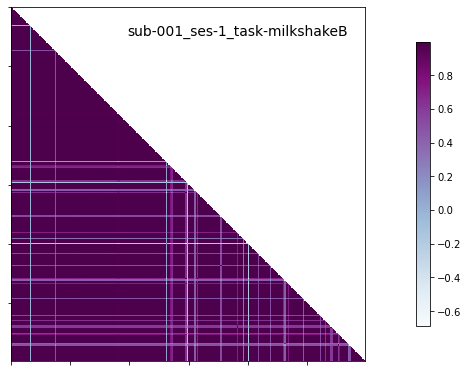

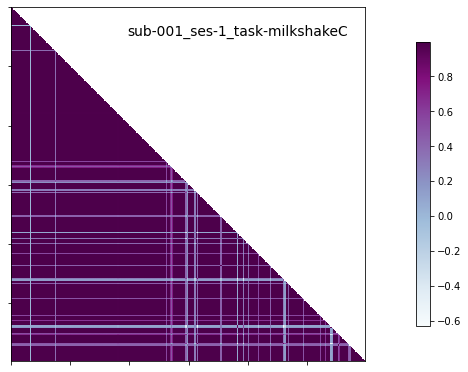

In [141]:

fc_corr_dict = {}
    
subj_list=[]
bad_subjects=[]
correlations = []
n_regions_extracted=300

    
for subj_timeseries in sorted(timeseries_files):
    #print(subj_timeseries)
    
    subj_id=subj_timeseries.split("/")[-1].split("_")[0]
    task_id=subj_timeseries.split("/")[-1].split("_")[2].split(".")[0]

    
    if subj_id not in fc_corr_dict:
        fc_corr_dict[subj_id] = {}
                              
    if subj_id not in subj_list:
        subj_list.append(subj_id)
                              
    filename = subj_timeseries.split("/")[-1] #"%s_ses-1_%s.txt"%(subj_id, task_id)
    #print("\n[INFO] Subject Matrix: %s "%filename)
    title_str=filename.split(".")[0]
    
    try:
        # we load the text file timeseries into an array 
        np_arr = np.loadtxt(subj_timeseries)
        #print(np_arr)
        
        
        # call fit_transform from ConnectivityMeasure object
        correlation_matrix = connectome_measure.fit_transform([np_arr])[0]
        #correlations.append(correlation)
        #print('[INFO] CORRELATION: ', correlation_matrix)
        
        # Mask out the major diagonal
        np.fill_diagonal(correlation_matrix, 0)
        # plot subject correlation matrix
        plotting.plot_matrix(correlation_matrix, cmap=cmap, colorbar=True,title=title_str, tri='lower')
        
        # save correlation as textfile
        #np.savetxt('/content/'+filename, correlation.transpose(2,0,1).reshape(3,-1))
    
    except:
        bad_subjects.append(subj_id)
        pass


In [2]:
!squeue -u nbytes

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3305425     batch timeseri   nbytes  R 1-03:57:41      1 largemem-0-0


4